### Feathers in Focus: AML 2025 Kaggle Challenge 🪶
### Athina Papatriantafyllou • Alexandra Holíková • Buğra Sipahioğlu

### Setup Instructions
> **Setup Commands (in terminal):**
> ```bash
> python -m venv venv
> source venv/bin/activate
> pip install -r requirements.txt
> ```
> **Download the data and unzip it under "data/raw":** https://www.kaggle.com/competitions/aml-2025-feathers-in-focus/data

### Import the Libraries

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageStat
from sklearn.model_selection import train_test_split
from torchvision.io import decode_image
from torch.utils.data import Dataset
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader

### Define the constants (So that it's easier to change some of them.)

In [2]:
# Data path constants 
DATA_DIR = "../data/raw"
TRAIN_CSV_PATH = f"{DATA_DIR}/train_images.csv"
TEST_CSV_PATH = f"{DATA_DIR}/test_images_path.csv"
CLASS_NAMES_PATH = f"{DATA_DIR}/class_names.npy"
ATTRIBUTES_PATH = f"{DATA_DIR}/attributes.npy"
ATTRIBUTES_TXT_PATH = f"{DATA_DIR}/attributes.txt"
TRAIN_IMAGES_BASE_PATH = f"{DATA_DIR}/train_images"
TEST_IMAGES_BASE_PATH = f"{DATA_DIR}/test_images"

# Dataset constants
VAL_SPLIT_RATIO = 0.2  # 20% validation 80% test for instance. 
RANDOM_STATE = 45  # Keep the same random state across runs for reproducibility
NUM_CLASSES = 200 # It's given in the Kaggle competition description, so we don't need to count it (yet it's counted in EDA part)

# Image transformation constants
IMAGE_SIZE = 224  # Final image size after transformations
RESIZE_SIZE = 256  # Size before center crop for validation/test
RANDOM_CROP_SCALE = (0.7, 1.0)  # RandomResizedCrop scale range
HORIZONTAL_FLIP_PROB = 0.5  # RandomHorizontalFlip probability
ROTATION_DEGREES = 15  # RandomRotation degrees
COLOR_JITTER_BRIGHTNESS = 0.2
COLOR_JITTER_CONTRAST = 0.25
COLOR_JITTER_SATURATION = 0.25
COLOR_JITTER_HUE = 0.15

# Normalization constants (ImageNet normalization statistics since pretrained models are usually trained on ImageNet)
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# Device constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE_CPU = 16
BATCH_SIZE_GPU = 32
BATCH_SIZE_MPS = 32
NUM_WORKERS_CPU = 0
NUM_WORKERS_GPU = 0
NUM_WORKERS_MPS = 0
PIN_MEMORY_CPU = False
PIN_MEMORY_GPU = True
PIN_MEMORY_MPS = False

### Load the data

In [3]:
# Load the training and test sets
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
class_names = np.load(CLASS_NAMES_PATH, allow_pickle=True).item()

# Load attributes
attributes = np.load(ATTRIBUTES_PATH, allow_pickle=True)
with open(ATTRIBUTES_TXT_PATH, "r") as f:
    attribute_names = [line.strip().split(' ', 1)[1] for line in f.readlines()]

# Print the data summary
print("Loading the data....")
print(f"-Train Size: {len(train_df)} \n-Test Size: {len(test_df)} \n-Number of Classes: {len(class_names)}")
print(f"-Attributes: {len(attribute_names)} (shape: {attributes.shape if hasattr(attributes, 'shape') else 'N/A'})")


Loading the data....
-Train Size: 3926 
-Test Size: 4000 
-Number of Classes: 200
-Attributes: 312 (shape: (200, 312))


### Explore the data

Random images (with their labels)from the training set:


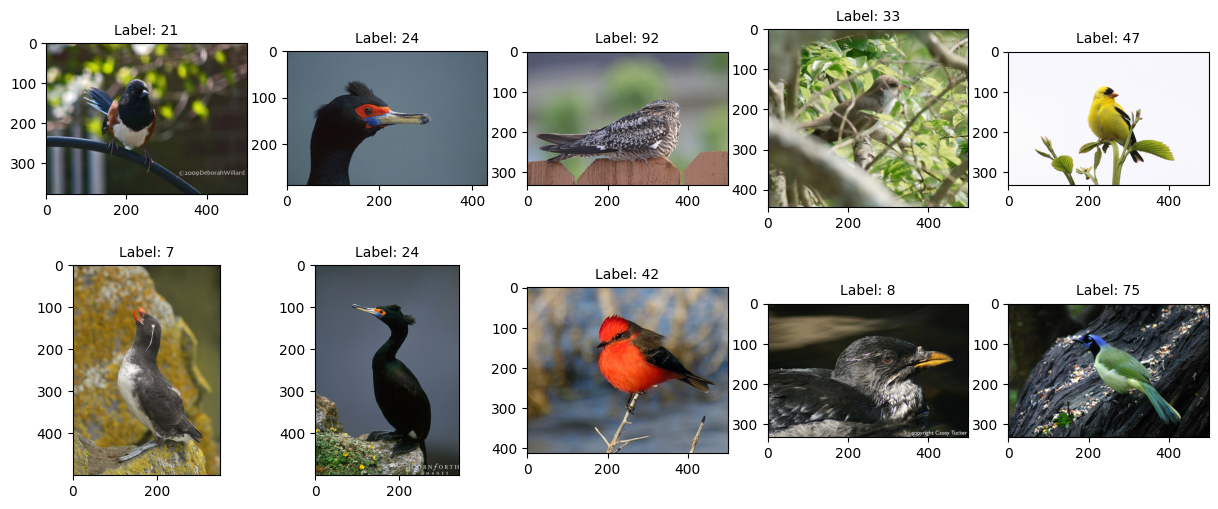

In [4]:
# Inspect the training set by showing 10 random images
print("Random images (with their labels)from the training set:")
samples = train_df.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (_, row) in zip(axes.flat, samples.iterrows()):
    img = Image.open(f"{TRAIN_IMAGES_BASE_PATH}{row['image_path']}")
    label_name = class_names.get(row['label'], f"Label: {row['label']}")
    ax.set_title(label_name, fontsize=10)
    ax.imshow(img)
plt.show()

Checking 3926 images' dimensions: 
-Width: min=140, max=500, mean=467.78
-Height: min=120, max=500, mean=385.37


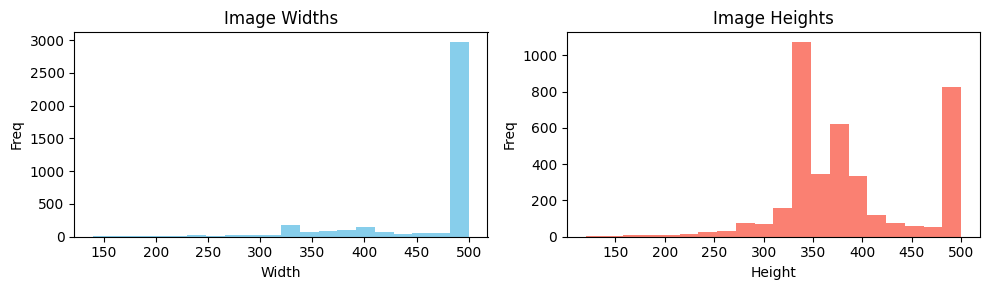

In [5]:
# Check image dimensions in the training set (concise version)
sizes = []
for p in train_df['image_path']:
    sizes.append(Image.open(f"{TRAIN_IMAGES_BASE_PATH}{p}").size)
widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]
print(f"Checking {len(widths)} images' dimensions: \n-Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.2f}\n-Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.2f}")

fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(widths, bins=20, color='skyblue'), axs[0].set(title='Image Widths', xlabel='Width', ylabel='Freq')
axs[1].hist(heights, bins=20, color='salmon'), axs[1].set(title='Image Heights', xlabel='Height', ylabel='Freq')
plt.tight_layout()
plt.show()

In [6]:
# Inspect the attributes
attributes_df = pd.DataFrame({'Index': range(len(attribute_names)), 'Attribute Name': attribute_names})
print("Attributes:")
display(attributes_df.head(10))

Attributes:


,Index,Attribute Name
0,0,has_bill_shape::curved_(up_or_down)
1,1,has_bill_shape::dagger
2,2,has_bill_shape::hooked
3,3,has_bill_shape::needle
4,4,has_bill_shape::hooked_seabird
5,5,has_bill_shape::spatulate
6,6,has_bill_shape::all-purpose
7,7,has_bill_shape::cone
8,8,has_bill_shape::specialized
9,9,has_wing_color::blue


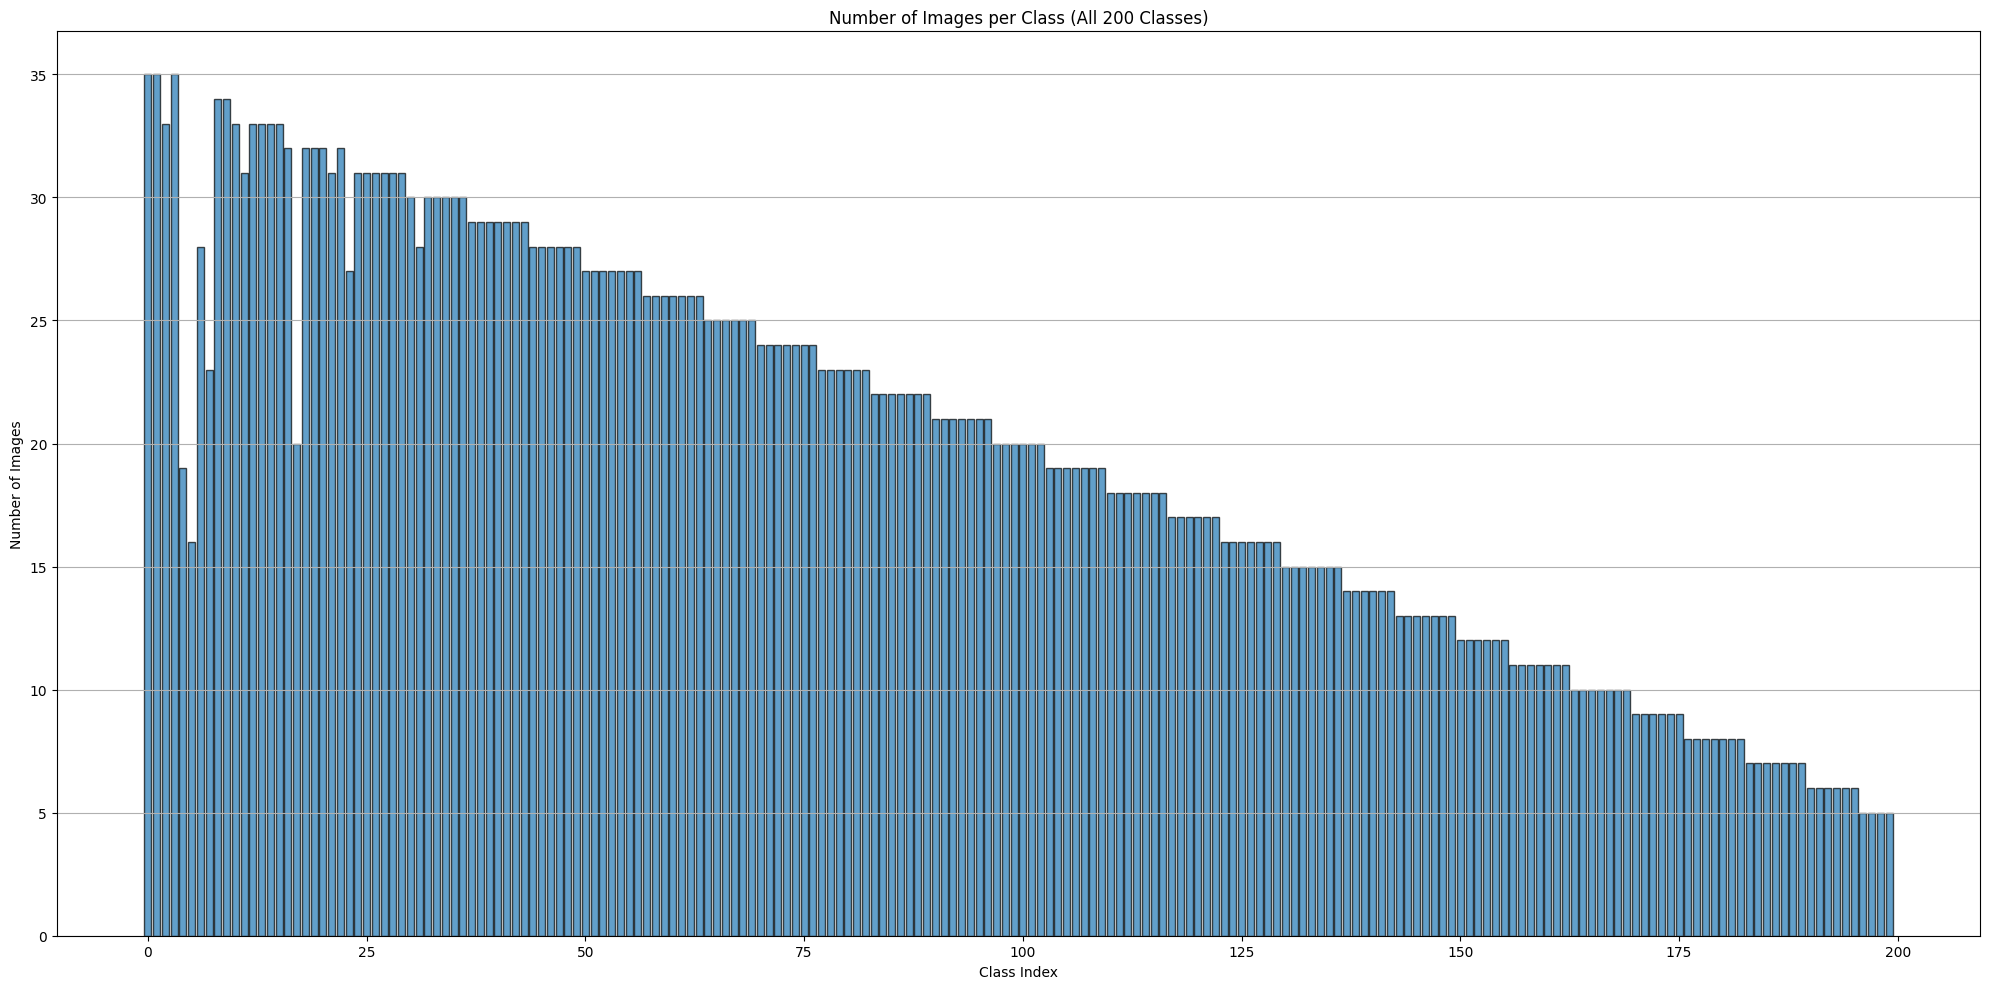

Statistics:
-Number of unique classes: 200
-Average number of images per class: 19.63
-Standard deviation of images per class: 8.39 (Lower the std, more balanced the dataset)
-Minimum number of images per class: 5
-Maximum number of images per class: 35


In [7]:
# Plot the class distribution to inspect the balance
class_counts = train_df['label'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(20, 10))

# Show the count for each class
ax.bar(range(len(class_counts)), class_counts.values, tick_label=None, edgecolor='k', alpha=0.7)
ax.set_xlabel('Class Index')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (All 200 Classes)')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# Statistics
print("Statistics:")
print(f"-Number of unique classes: {len(class_names)}")
print(f"-Average number of images per class: {class_counts.mean():.2f}")
print(f"-Standard deviation of images per class: {class_counts.std():.2f} (Lower the std, more balanced the dataset)")
print(f"-Minimum number of images per class: {class_counts.min()}")
print(f"-Maximum number of images per class: {class_counts.max()}")


In [8]:
# Check for Corrupted Images

# Check Training Set
corrupt_counter_train = 0
for idx, row in train_df.iterrows():
    img_path = f"{TRAIN_IMAGES_BASE_PATH}{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_train += 1

# Check Test Set
corrupt_counter_test = 0
for idx, row in test_df.iterrows():
    img_path = f"{TEST_IMAGES_BASE_PATH}{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_test += 1

# Print the results
print(f"Total corrupt images in training set: {corrupt_counter_train}")
print(f"Total corrupt images in test set: {corrupt_counter_test}")


Total corrupt images in training set: 0
Total corrupt images in test set: 0


In [9]:
# Check the color stats for all training images
def get_color_stats(image_path):
    img = Image.open(image_path).convert('RGB')
    stat = ImageStat.Stat(img)
    brightness = sum(stat.mean) / len(stat.mean)
    contrast = sum(stat.stddev) / len(stat.stddev)
    saturation = max(stat.mean) - min(stat.mean)
    return brightness, contrast, saturation

stats = [get_color_stats(f"{TRAIN_IMAGES_BASE_PATH}{p}") for p in train_df['image_path']]
brightnesses = [s[0] for s in stats]
contrasts = [s[1] for s in stats]
saturations = [s[2] for s in stats]

print(f"Color Statistics:")
print(f"- Brightness: mean={np.mean(brightnesses):.2f}, std={np.std(brightnesses):.2f}, range=[{min(brightnesses):.2f}, {max(brightnesses):.2f}]")
print(f"- Contrast: mean={np.mean(contrasts):.2f}, std={np.std(contrasts):.2f}, range=[{min(contrasts):.2f}, {max(contrasts):.2f}]")
print(f"- Saturation: mean={np.mean(saturations):.2f}, std={np.std(saturations):.2f}, range=[{min(saturations):.2f}, {max(saturations):.2f}]")
print("\nWISE WORDS FROM THE ML GODS:")
print("- High variance values indicate that our images already have diverse properties.\n- Hence, we don't need to use (high parameters for) ColorJitter.")

Color Statistics:
- Brightness: mean=121.81, std=33.72, range=[18.69, 244.95]
- Contrast: mean=47.22, std=14.21, range=[11.51, 106.21]
- Saturation: mean=32.34, std=25.01, range=[0.00, 178.80]

WISE WORDS FROM THE ML GODS:
- High variance values indicate that our images already have diverse properties.
- Hence, we don't need to use (high parameters for) ColorJitter.


### Split the data into training, validation and test sets

In [10]:
# Extract image paths and labels
X = train_df['image_path'].values
y = train_df['label'].values       

# Look at indices of labels (Y)
print("Before correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Since the labels start from 1, convert them to 0-indexed
y = y - 1

print("After correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Split the data into training and validation sets (80% train, 20% validation)
X_test = test_df['image_path'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size = VAL_SPLIT_RATIO, 
    random_state = RANDOM_STATE, # keep the same random state across runs for reproducibility
    stratify = y  # Maintains class distribution in both sets
)

Before correction:
- y indices min: 1
- y indices max: 200
After correction:
- y indices min: 0
- y indices max: 199


### Define the transformations

In [11]:
# Transformations for training set
transformation_training = v2.Compose([

    # Randomly crop to IMAGE_SIZE from a resized area of the image.
    # - Scale controls how much of the original image area we keep (tunable via RANDOM_CROP_SCALE).
    # - Since feathers require fine details, we keep the scale high.
    # - Antialias=True is used to improve the quality of the resized image.
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=RANDOM_CROP_SCALE, antialias=True),
    
    # Random horizontal flip (tunable via HORIZONTAL_FLIP_PROB)
    v2.RandomHorizontalFlip(p=HORIZONTAL_FLIP_PROB), 
    
    # Random rotation (tunable via ROTATION_DEGREES)
    v2.RandomRotation(degrees=ROTATION_DEGREES), 
    
    # Color jitter (tunable via COLOR_JITTER constants)
    # Kept small since the stats of the training images are already diverse.
    # Strong color augmentations can distort the images and make the model more confused.
    v2.ColorJitter(
        brightness=COLOR_JITTER_BRIGHTNESS, 
        contrast=COLOR_JITTER_CONTRAST, 
        saturation=COLOR_JITTER_SATURATION, 
        hue=COLOR_JITTER_HUE
    ), 
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
    
    # Normalize the image (ImageNet stats for pretrained models, tunable)
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD), 
])

# Transformations for validation set
transformation_validation = v2.Compose([
    
    # Resize to RESIZE_SIZE (no randomness for consistent validation)
    v2.Resize(RESIZE_SIZE, antialias=True),

    # Center crop to IMAGE_SIZE (matches the training set)
    v2.CenterCrop(IMAGE_SIZE),
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
     
    # Normalize the image (must match the training normalization)
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

### Create Custom Dataset for PyTorch

In [12]:
# Pytorch needs a custom dataset to load and transform the data
class FeatherImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transformation=None, target_transformation=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transformation = transformation
        self.target_transformation = target_transformation
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, i):
        image_path = self.image_paths[i]
        image_label = self.image_labels[i]  
        image = decode_image(image_path)
        if self.transformation:
            image = self.transformation(image)
        if self.target_transformation:
            image_label = self.target_transformation(image_label)
        return image, image_label

### Create Dataset Instances and DataLoaders

In [13]:
# Create dataset instances with transformations
# Create custom dataset instance for training set
train_dataset = FeatherImageDataset(
    image_paths = [TRAIN_IMAGES_BASE_PATH + path for path in X_train],
    image_labels = y_train,
    transformation = transformation_training
)

# Create custom dataset instance for validation set
val_dataset = FeatherImageDataset(
    image_paths = [TRAIN_IMAGES_BASE_PATH + path for path in X_val],
    image_labels = y_val,
    transformation = transformation_validation
)

# Check device availability
# - If GPU is available, use it
# - If MPS is available, use it (GPU supportfor Apple Silicon)
# - Otherwise, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
if device.type == 'cuda':
    batch_size = BATCH_SIZE_GPU
    num_workers = NUM_WORKERS_GPU # Set to 0 for Jupyter notebooks as they might fail with too many workers
    pin_memory = PIN_MEMORY_GPU  # FYI: Pin memory speeds up the transfer data from CPU RAM to GPU vRAM
elif device.type == 'mps':
    batch_size = BATCH_SIZE_MPS
    num_workers = NUM_WORKERS_MPS
    pin_memory = PIN_MEMORY_MPS  # MPS doesn't support pin_memory
else:
    batch_size = BATCH_SIZE_CPU
    num_workers = NUM_WORKERS_CPU
    pin_memory = PIN_MEMORY_CPU  # Not needed for CPU (since it's used to speed up the transfer data from CPU RAM to GPU vRAM)

# Print the DataLoader configuration
print("DataLoader configuration:")
print(f"- Using device: {device}")
print(f"- Batch size: {batch_size}")
print(f"- Number of workers: {num_workers} (0 = main process, avoids pickling issues in Jupyter)")
print(f"- Pin memory: {pin_memory}")

# Create DataLoader for training set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle training data so that the model doesn't memorize the order of the data
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Create DataLoader for validation set
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle validation data: So that each time we use the validation, it's the same
    num_workers=num_workers,
    pin_memory=pin_memory  
)

# Print the final information
print(f"\nSetup:")
print(f"- Train dataset: {len(train_dataset)} samples")
print(f"- Validation dataset: {len(val_dataset)} samples")
print(f"- Batch size: {batch_size}")

DataLoader configuration:
- Using device: mps
- Batch size: 32
- Number of workers: 0 (0 = main process, avoids pickling issues in Jupyter)
- Pin memory: False

Setup:
- Train dataset: 3140 samples
- Validation dataset: 786 samples
- Batch size: 32


### Hugging face for Baseline

In [14]:
# Load model and utilities from the models package
from transformers import AutoImageProcessor, AutoModelForImageClassification
import models.baseline_hf as baseline_hf

# Load the model and processor
processor = AutoImageProcessor.from_pretrained("Emiel/cub-200-bird-classifier-swin")
model = AutoModelForImageClassification.from_pretrained("Emiel/cub-200-bird-classifier-swin")

# Create dataloaders using the helper function
train_loader_hf, val_loader_hf = baseline_hf.create_hf_dataloaders(
    train_image_paths=TRAIN_IMAGES_BASE_PATH,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    processor=processor,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Validate the model and print the accuracy
acc = baseline_hf.validate_hf(model, val_loader_hf, device)
print(f"HF Swin validation accuracy: {acc:.3f} ({acc*100:.1f}%)")

/Users/bugrasipahioglu/repo/aml-2025-feathers/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


HF Swin validation accuracy: 0.981 (98.1%)


### TODO: (Alexandra) Push the results into the Kaggle

In [15]:
from export import export_hf

export_hf(
    model=model,                      # HF model
    processor=processor,              # HF processor
    test_df=test_df,                  # test_images_path.csv as DataFrame
    test_images_base_path=TEST_IMAGES_BASE_PATH,
    device=DEVICE,
    batch_size=batch_size,
    output_path="submission_hf.csv"
)

Exporting HF: 100%|██████████| 125/125 [21:11<00:00, 10.18s/it]

✅ HF submission saved to submission_hf.csv


### Our First Model: ChickenCNN

CNN model
Low accuracy

In [ ]:
# Import the model and training functions
from models.chicken_cnn import ChickenCNN
import torch
import torch.nn as nn
from train import train
from validate import validate

# Print the device
print(f"Using device: {DEVICE}")

# Initialize the ChickenCNN model
model = ChickenCNN(num_classes=NUM_CLASSES).to(DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define epochs
EPOCHS = 5

# Train the model
trained_model = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=EPOCHS
)

# Print information about the training
print(f"\nTraining ChickenCNN with augmented transforms...")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")
print(f"- Batch size: {batch_size}")


# Final validation
final_acc = validate(trained_model, val_loader, DEVICE)
print(f"\nFinal Validation Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")

### Our Final Model BIRDY CNN --> (CNN v1 + augmentation)

#### Load data, transform etc.

In [ ]:
# Import the model and training functions
import torch
import torch.nn as nn
from models.birdy_cnn import BirdyCNN
from train import train
from validate import validate

# Define the constants for augmentation
IMAGE_SIZE = 224
NUM_CLASSES = 200
IMAGE_SCALE = (0.8, 1.0)
IMAGE_ROTATION = 10
IMAGE_BRIGHTNESS = 0.2
IMAGE_CONTRAST = 0.2
IMAGE_FLIP = 0.5

# Define augmented transforms for training
transform_aug = v2.Compose([
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=IMAGE_SCALE),
    v2.RandomHorizontalFlip(p=IMAGE_FLIP),
    v2.RandomRotation(degrees=IMAGE_ROTATION),
    v2.ColorJitter(brightness=IMAGE_BRIGHTNESS, contrast=IMAGE_CONTRAST),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# Create training dataset with augmented transforms
train_dataset_aug = FeatherImageDataset(
    image_paths=[TRAIN_IMAGES_BASE_PATH + path for path in X_train],
    image_labels=y_train,
    transformation=transform_aug
)

# Create DataLoader for training with augmentation
train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

#### Run the BIRDY model without K-Fold Cross Validation

In [ ]:
# Initialize the BirdyCNN model
model = BirdyCNN(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES).to(DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(f"Using device: {DEVICE}")
print(f"\nTraining BirdyCNN with augmented transforms...")
print(f"- Training samples: {len(train_dataset_aug)}")
print(f"- Validation samples: {len(val_dataset)}")
print(f"- Batch size: {batch_size}")

# Train the model
trained_model = train(
    model=model,
    train_loader=train_loader_aug,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=10
)

# Final validation
final_acc = validate(trained_model, val_loader, DEVICE)
print(f"\nFinal Validation Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")



#### Run the BIRDY Model With K-Fold Validation

In [ ]:
# Import k-fold CV function
from validate import k_fold_cross_validate
from models.birdy_cnn import BirdyCNN
import numpy as np

# Combine train and val data for k-fold
if isinstance(X_train, np.ndarray):
    X_all = np.concatenate([X_train, X_val])
    y_all = np.concatenate([y_train, y_val])
else:
    X_all = pd.concat([X_train, X_val]).reset_index(drop=True).values
    y_all = pd.concat([y_train, y_val]).reset_index(drop=True).values

print(f"Running K-Fold Cross Validation on BirdyCNN")
print(f"Combined dataset size: {len(X_all)} samples")
print(f"=" * 70)

# Define base transform (no augmentation) for validation folds
transform_base = v2.Compose([
    v2.Resize(RESIZE_SIZE, antialias=True),
    v2.CenterCrop(IMAGE_SIZE),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# Run k-fold cross validation
birdy_kfold_results = k_fold_cross_validate(
    model_class=BirdyCNN,
    X_data=X_all,
    y_data=y_all,
    dataset_class=FeatherImageDataset,
    transform=transform_aug,  # Use augmentation for training folds
    transform_base=transform_base,  # No augmentation for validation folds
    IMAGES_BASE_PATH=TRAIN_IMAGES_BASE_PATH,
    IMAGE_SIZE=IMAGE_SIZE,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    k=5,  # 5-fold cross validation
    num_epochs=20,  # Same as original training
    batch_size=32,
    lr=1e-4,  # Same learning rate as original
    seed=42,
    verbose=True
)

# Print final results
print(f"\n{'='*70}")
print(f"BirdyCNN K-Fold Cross Validation Results:")
print(f"{'='*70}")
print(f"Mean Accuracy: {birdy_kfold_results['mean_accuracy']:.4f} ({birdy_kfold_results['mean_accuracy']*100:.2f}%)")
print(f"Std Accuracy:  {birdy_kfold_results['std_accuracy']:.4f}")
print(f"Final Result:  {birdy_kfold_results['mean_accuracy']:.4f} ± {birdy_kfold_results['std_accuracy']:.4f}")
print(f"\nFold-by-fold accuracies:")
for i, acc in enumerate(birdy_kfold_results['all_fold_accuracies'], 1):
    print(f"  Fold {i}: {acc:.4f} ({acc*100:.2f}%)")
print(f"\nMin: {min(birdy_kfold_results['all_fold_accuracies']):.4f}, Max: {max(birdy_kfold_results['all_fold_accuracies']):.4f}")
print(f"{'='*70}")

### Ablation Study: Model comparison with deeper layer and augmentation

#### Run the ablation Study Without K-fold Cross Validation

**Aim**: To see whether adding an extra layer (SimpleCNNv2) and/or adding augmentation works. 

**Combinations from these options:** CNNv1, CNNv2, augmentation added or augmentation not added

In [ ]:
from models.simple_cnn_v1 import SimpleCNNv1
from models.simple_cnn_v2 import SimpleCNNv2
from ablation import run_ablation
 
# Define the augmentation parameters
# Baseline transforms (no aug)
transform_base = v2.Compose([
    v2.Resize(RESIZE_SIZE, antialias=True),
    v2.CenterCrop(IMAGE_SIZE),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# Augmented transforms
transform_aug = v2.Compose([
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# Run the ablation study with model classes (not instances)
models = {'SimpleCNN-v1': SimpleCNNv1, 'SimpleCNN-v2': SimpleCNNv2}
transforms_dict = {'baseline': transform_base, 'augmented': transform_aug}
results_df = run_ablation(
    models=models,
    transforms_dict=transforms_dict,
    dataset_class=FeatherImageDataset,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    TRAIN_IMAGES_BASE_PATH=TRAIN_IMAGES_BASE_PATH,
    IMAGE_SIZE=IMAGE_SIZE,
    device=DEVICE,
    transform_base=transform_base,
    num_classes=NUM_CLASSES
)

# Print the results and summary
print(results_df)
summary = (results_df
           .groupby(['model', 'augmentation'])
           .agg(val_acc_mean=('best_val_acc', 'mean'),
                val_acc_std=('best_val_acc', 'std'),
                params=('params', 'first'))
           .round(4))
print(summary)

#### Run the ablation Study With K-fold Cross Validation

**Aim**: To see whether using K-fold validation improves the results with limited data. 

**Combinations from these options:** CNNv1, CNNv2, augmentation added or augmentation not added

In [ ]:
# Import k-fold functions
from validate import k_fold_cross_validate
from ablation import run_ablation_kfold
from models.simple_cnn_v1 import SimpleCNNv1
from models.simple_cnn_v2 import SimpleCNNv2
import numpy as np

# Combine train and val data for k-fold
if isinstance(X_train, np.ndarray):
    X_all = np.concatenate([X_train, X_val])
    y_all = np.concatenate([y_train, y_val])
else:
    X_all = pd.concat([X_train, X_val]).reset_index(drop=True).values
    y_all = pd.concat([y_train, y_val]).reset_index(drop=True).values

print(f"Combined dataset size: {len(X_all)} samples")
print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}")

# Test k-fold CV on a single model (SimpleCNN-v1 with augmentation)
print("\n" + "="*70)
print("Testing K-Fold Cross Validation on SimpleCNN-v1 with augmentation")
print("="*70)

# Define the augmentation parameters
# Baseline transforms (no aug)
transform_base = v2.Compose([
    v2.Resize(RESIZE_SIZE, antialias=True),
    v2.CenterCrop(IMAGE_SIZE),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# Augmented transforms
transform_aug = v2.Compose([
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

results_kfold_df = run_ablation_kfold(
    models={'SimpleCNN-v1': SimpleCNNv1, 'SimpleCNN-v2': SimpleCNNv2},
    transforms_dict={'baseline': transform_base, 'augmented': transform_aug},
    dataset_class=FeatherImageDataset,
    X_data=X_all,  # Already numpy array
    y_data=y_all,  # Already numpy array
    TRAIN_IMAGES_BASE_PATH=TRAIN_IMAGES_BASE_PATH,
    IMAGE_SIZE=IMAGE_SIZE,
    device=DEVICE,
    transform_base=transform_base,
    num_classes=NUM_CLASSES,
    k=3,  # 5-fold cross validation
    seeds=[42],  # Use fewer seeds since k-fold provides variance estimate
    epochs=15,
    batch_size=32,
    lr=0.001
)

print("\nK-Fold Ablation Results:")
print(results_kfold_df[['model', 'augmentation', 'mean_val_acc', 'std_val_acc', 'params']])

# Compare with regular ablation
print("\nComparison: Regular vs K-Fold Results")
print("\nRegular Ablation (single split):")
print(results_df.groupby(['model', 'augmentation'])['best_val_acc'].agg(['mean', 'std']))
print("\nK-Fold Ablation (averaged across folds):")
print(results_kfold_df[['model', 'augmentation', 'mean_val_acc', 'std_val_acc']])

### Grid Search

#### Grid Search Without K-Fold Validation

In [ ]:
import itertools
import time

# Define the hyperparameter grid
param_grid = {
    # Controls the step size during gradient descent. Too high a value can cause instability; too low can slow convergence.
    'learning_rate': [1e-1, 1e-3, 1e-5],
    'batch_size': [16, 32], # Influences training stability and convergence speed
    'num_epochs': [20, 30], # Determines the number of training epochs
    'optimizer': ['adam', 'sgd'], # Determines the optimizer to use
    'dropout_rate': [0.0, 0.3, 0.5], # Dropout rate for regularization
    'l2_weight': [0.0, 1e-5, 1e-2], # L2 regularization weight (weight decay)
}

# Store results
grid_search_results = []

print(f"Starting Grid Search...")
print(f"Total combinations: {len(list(itertools.product(*param_grid.values())))}")
print(f"Parameter grid:")
for key, values in param_grid.items():
    print(f"  {key}: {values}")
print(f"\n{'='*80}\n")

# Iterate through all combinations
for idx, params in enumerate(itertools.product(*param_grid.values())):
    lr, batch_size_gs, epochs, opt_name, dropout, l2= params
    start_time = time.time()
    
    try:
        # Create new data loaders with the current batch size
        train_loader_gs = DataLoader(
            train_dataset_aug,
            batch_size=batch_size_gs,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        
        val_loader_gs = DataLoader(
            val_dataset,
            batch_size=batch_size_gs,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        
        # Initialize a fresh model with current hyperparameters
        model_gs = BirdyCNN(
            image_size=IMAGE_SIZE, 
            num_classes=NUM_CLASSES,
            dropout_rate=dropout
        ).to(DEVICE)
        
        # Define criterion
        criterion_gs = nn.CrossEntropyLoss()
        
        # Select optimizer with L2 regularization (weight_decay)
        if opt_name == 'adam':
            optimizer_gs = torch.optim.Adam(model_gs.parameters(), lr=lr, weight_decay=l2)
        elif opt_name == 'sgd':
            optimizer_gs = torch.optim.SGD(model_gs.parameters(), lr=lr, momentum=0.9, weight_decay=l2)
        
        # Train the model
        print(f"Training...")
        trained_model_gs = train(
            model=model_gs,
            train_loader=train_loader_gs,
            val_loader=val_loader_gs,
            criterion=criterion_gs,
            optimizer=optimizer_gs,
            device=DEVICE,
            num_epochs=epochs
        )
        
        # Validate
        final_val_acc = validate(trained_model_gs, val_loader_gs, DEVICE)
        
        elapsed_time = time.time() - start_time
        
        # Store results
        result = {
            'learning_rate': lr,
            'batch_size': batch_size_gs,
            'num_epochs': epochs,
            'optimizer': opt_name,
            'dropout_rate': dropout,
            'l2_weight': l2,
            'val_accuracy': final_val_acc,
            'training_time': elapsed_time
        }
        grid_search_results.append(result)
        
        print(f"  ✓ Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
        print(f"  ✓ Training Time: {elapsed_time:.2f}s")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        result = {
            'learning_rate': lr,
            'batch_size': batch_size_gs,
            'num_epochs': epochs,
            'optimizer': opt_name,
            'dropout_rate': dropout,
            'l2_weight': l2,
            'val_accuracy': None,
            'training_time': None,
            'error': str(e)
        }
        grid_search_results.append(result)

print(f"Grid Search Completed!")
print(f"Total experiments: {len(grid_search_results)}")

Process the Results

In [ ]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(grid_search_results)

# Sort by validation accuracy (descending)
results_df_sorted = results_df.sort_values('val_accuracy', ascending=False)

print("Grid Search Results:")
print(results_df_sorted.head(10).to_string(index=False))

print(f"\nBest Configuration:")
best_result = results_df_sorted.iloc[0]
for key, value in best_result.items():
    if key == 'val_accuracy' and value is not None:
        print(f"  {key}: {value:.4f} ({value*100:.2f}%)")
    elif key == 'val_loss' and value is not None:
        print(f"  {key}: {value:.4f}")
    elif key == 'training_time' and value is not None:
        print(f"  {key}: {value:.2f}s")
    else:
        print(f"  {key}: {value}")

# Display full results DataFrame
print(f"\n\nAll Results:")
print(results_df_sorted.to_string(index=False))

# Save results to CSV
output_path = '../data/grid_search_results.csv'
results_df_sorted.to_csv(output_path, index=False)
print(f"Grid search results saved to: {output_path}")

# Display summary statistics
print(f"\n\nSummary Statistics:")
print(results_df[['val_accuracy', 'training_time']].describe())

#### Grid Search With K-Fold Validation

In [ ]:
# TBI

### Submit to Kaggle

In [ ]:
# # ============================================================
# # Build test dataset, run inference, and create submission.csv
# # ============================================================

# # 1) Build HF-style test dataset (paths already in X_test)
# test_dataset_hf = FeatherImageDatasetHF(
#     [TEST_IMAGES_BASE_PATH + path for path in X_test],
#     image_labels=None,
#     processor=processor
# )

# test_loader_hf = DataLoader(
#     test_dataset_hf,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=num_workers,
#     pin_memory=pin_memory
# )

# # 2) Predict on all test images
# model.to(device)
# model.eval()

# all_preds = []

# with torch.no_grad():
#     for batch in test_loader_hf:
#         # batch only has inputs (no labels) for test
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         preds = outputs.logits.argmax(dim=1).cpu().numpy()
#         all_preds.extend(preds)

# all_preds = np.array(all_preds)

# # If competition labels are 1..200 (common for this dataset), shift from 0..199
# all_preds_kaggle = all_preds + 1

# # 3) Build submission DataFrame with columns: id,label
# #    Assumes test_images_path.csv has a column named "id"
# submission = pd.DataFrame({
#     "id": test_df["id"].values,
#     "label": all_preds_kaggle
# })

# print(submission.head())
# print("Submission shape:", submission.shape)

# # 4) Save to CSV for Kaggle upload
# submission.to_csv("submission.csv", index=False)
# print("Saved submission.csv")